In [1]:
print("Hello world !!")

Hello world !!


In [2]:
!ls

Dataset  drive	sample_data


In [3]:
!unzip -q "./drive/MyDrive/Sandbox1/test img 2.zip" -d "./Dataset/"

replace ./Dataset/test img 2/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!unzip -q "./drive/MyDrive/Sandbox1/test_images_2.zip" -d "./Dataset/"

replace ./Dataset/test_images_2/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [5]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [6]:
INPUT_PATH = "./Dataset/test_images_2"
OUTPUT_PATH = "./Dataset/test img 2"

In [7]:
class SandboxDataset(Dataset):
  def __init__(self, transform=None):
    self.dataroot = "./Dataset"
    self.images = os.listdir(INPUT_PATH)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.images[idx]
    input_path = read_image(f'{INPUT_PATH}/{img_path}') / 255
    output_path = read_image(f'{OUTPUT_PATH}/{img_path}') / 255

    if self.transform:
      input_path = self.transform(input_path)
      output_path = self.transform(output_path)

    # alpha_channel = torch.ones(1,150,150)

    # if input_path.shape[0] == 3:
    #   input_path = torch.cat((input_path, alpha_channel), dim=0)

    # if output_path.shape[0] == 3:
    #   output_path = torch.cat((output_path, alpha_channel), dim=0)

    # if input_path.shape[0] == 4:
    #   input_path = input_path[:3,:,:]
    # if output_path.shape[0] == 4:
    #   output_path = output_path[:3,:,:]

    return input_path, output_path

In [8]:
transform = transforms.Compose([transforms.Resize((150,150), antialias=False)])
dataset = SandboxDataset(transform=transform)

train_set, test_set = random_split(dataset, [0.8,0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

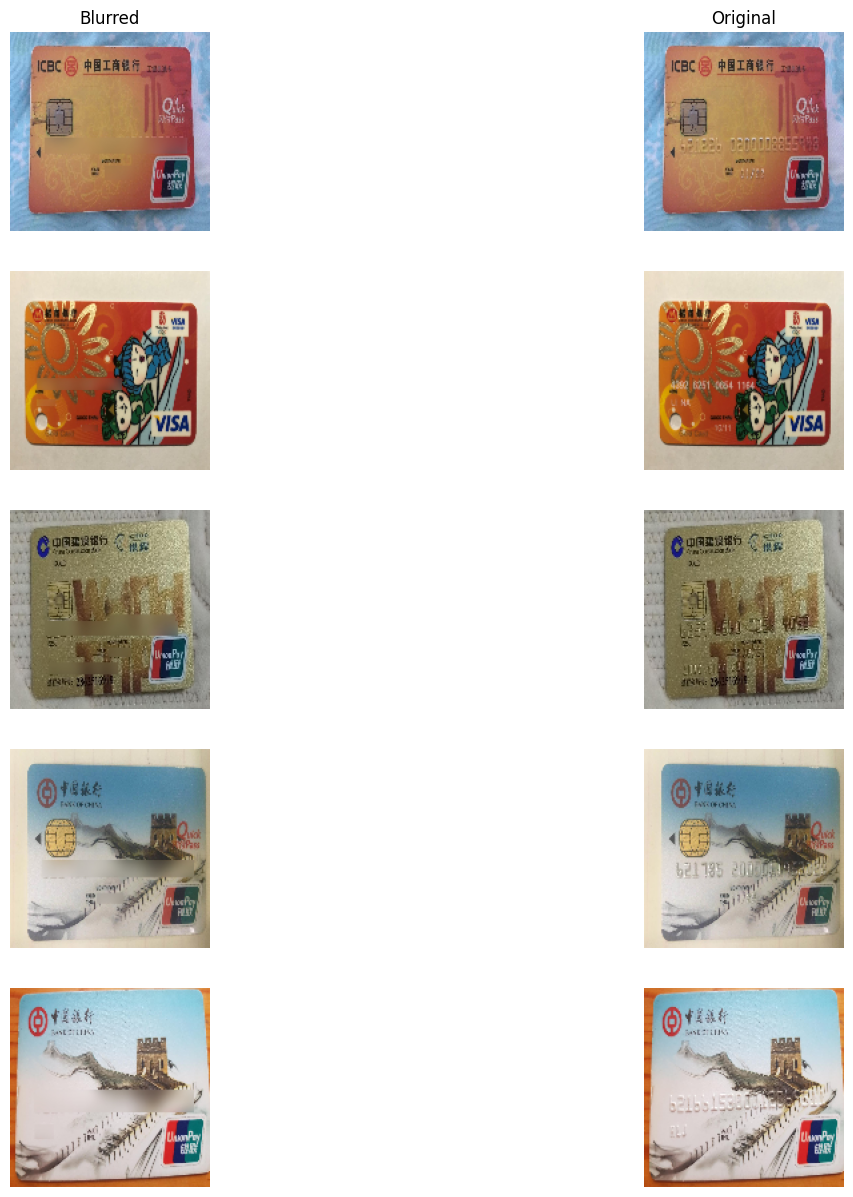

In [9]:
# Visualise Dataset

def show_images(original,blurred):
  fig, axs = plt.subplots(5,2,figsize=(15,15))
  axs[0,0].set_title('Blurred')
  axs[0,1].set_title('Original')

  for i in range(5):
    axs[i,0].imshow(blurred[i].permute(1,2,0))
    axs[i,0].axis('off')
    axs[i,1].imshow(original[i].permute(1,2,0))
    axs[i,1].axis('off')
  plt.show()

original, blurred = next(iter(trainloader))
show_images(original, blurred)

In [10]:
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [11]:
# class AutoEncoder(nn.Module):
#   def __init__(self):
#     super().__init__()

#     self.down1 = nn.Conv2d(3, 64, 3, stride=2)
#     self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
#     self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
#     self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)

#     self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
#     self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
#     self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
#     self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

#     self.relu = nn.ReLU()
#     self.sigmoid = nn.Sigmoid()

#   def forward(self,x):
#     d1 = self.relu(self.down1(x))
#     d2 = self.relu(self.down2(d1))
#     d3 = self.relu(self.down3(d2))
#     d4 = self.relu(self.down4(d3))

#     u1 = self.relu(self.up1(d4))
#     u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
#     u3 = self.relu(self.up3(torch.cat((u2,d2), dim=1)))
#     # u3 = self.relu(self.up3(d2))
#     u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

#     return u4

class RedactionRestorationModel(nn.Module):
    def __init__(self):
        super(RedactionRestorationModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))

        # Decoder
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv4(x))  # Output in [0, 1] range

        return x


In [12]:
model = RedactionRestorationModel().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ",total_params)

Total number of parameters:  3101443


In [13]:
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
for epoch in range(EPOCHS):
  running_loss = 0.0

  for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)

    predictions = model(gray_img)

    optimizer.zero_grad()
    loss = criterion(color_img, predictions)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'Epoch: {epoch+1}, Loss: {running_loss:.6f}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.400970


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.381716


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
total_loss = 0.0

with torch.no_grad():
  for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
    color_img = color_img.to(DEVICE)
    gray_img = gray_img.to(DEVICE)

    prediction = model(gray_img)
    loss = criterion(prediction, color_img)
    total_loss += loss.item()

  print(f"Total Testing Loss: {total_loss/len(testloader):.3f}")


  0%|          | 0/1 [00:00<?, ?it/s]

Total Testing Loss: 0.135


In [ ]:
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0))
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()

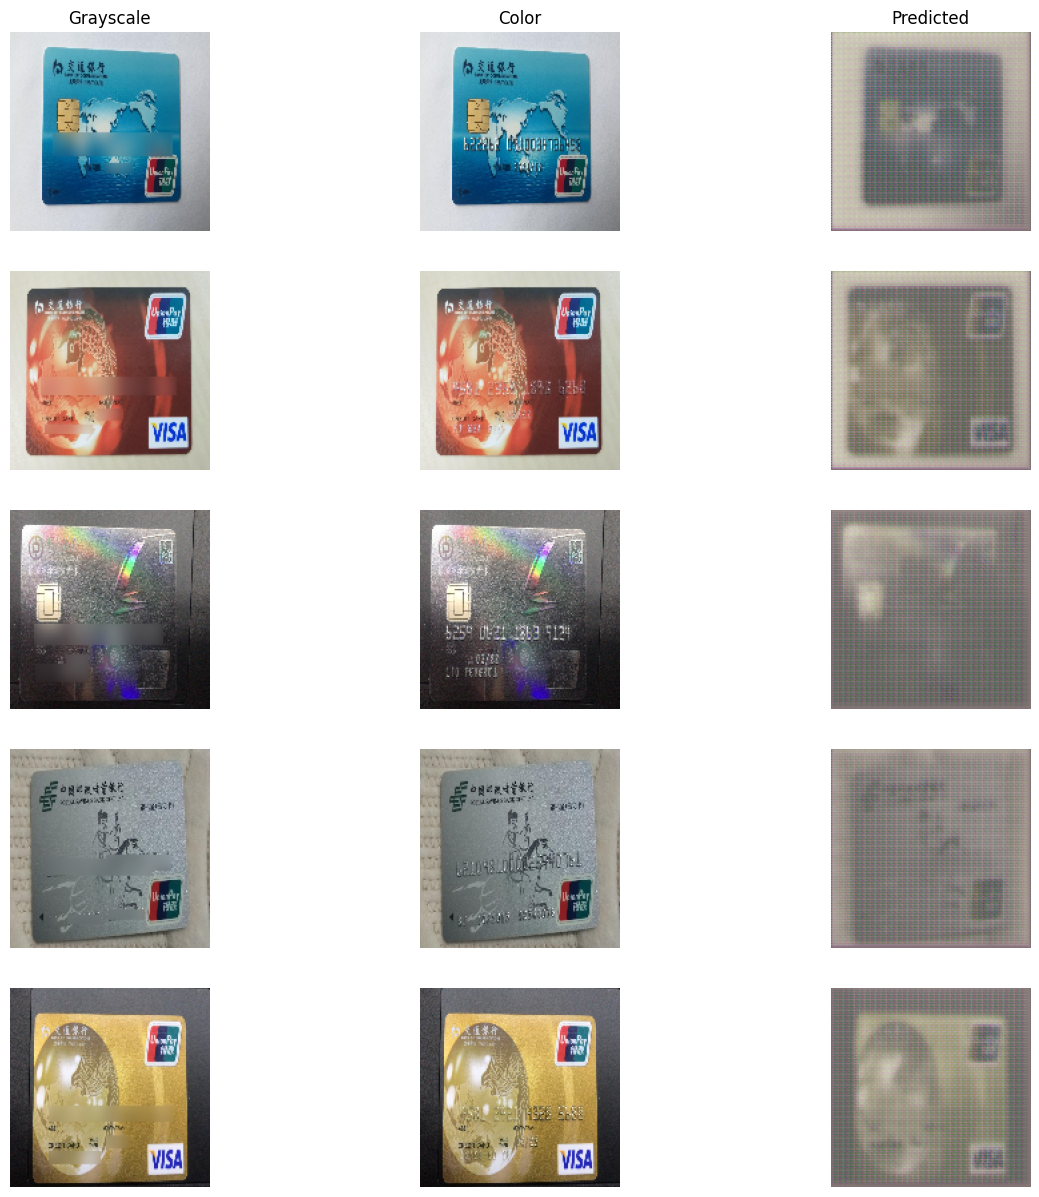

In [ ]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())